## Assignment 2
**Submission deadlines:** 
**Submission deadlines:** 
- get at least **4** points by lab session (week 24-28.03.2025)
- remaining points: by lab session (week 31.03-04.04.2025)

**Points:** Aim to get 16 out of 18+ possible points

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`

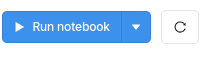

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

## Extra points

You can earn extra 2 points if all your experiments are logged with [Weights and Biases](http://wandb.ai)


# Problems


## Problem 1 [2p]:

Let's see why GPUs are useful in deep learning. Compare matrix multiplication speed for a few matrix shapes when implemented:
1. as loops in Python
2. using np.einsum
3. using numpy on CPU
4. using pytorch on CPU
5. using pytorch on GPU

Finally, consider two square matrices, $A$ and $B$. We have 4 possibilities of multiplying them or their transpositions:
1. $AB$
2. $A^TB$
3. $AB^T$
4. $A^TB^T$

Which option is the fastest? Why?

In [1]:
import itertools
import numpy as np
import torch

def matrix_mul_loop(a, b):
  n, k, m = a.shape[0], a.shape[1], b.shape[1]
  assert k == b.shape[0]
  c = np.zeros((n, m))
  for (i, j) in itertools.product(range(n), range(m)):
    c[i, j] = sum(a[i, l] * b[l, j] for l in range(k))
  return c

def matrix_mul_einsum(a, b):
  # return np.einsum('ik,kj->ij', a, b)
  return np.einsum('ik,kj', a, b)

def matrix_mul_np(a, b):
  return np.matmul(a, b)  # or simply return a @ b

def matrix_mul_cpu(a, b):
  # lets include conversion to tensor in timing for simplicity, its nevertheless of lesser complexity (so a trend should show still)
  torch.matmul(torch.tensor(a, device='cpu'), torch.tensor(b, device='cpu'))

def matrix_mul_gpu(a, b):
  # lets include conversion to tensor in timing for simplicity, its nevertheless of lesser complexity (so a trend should show still)
  torch.matmul(torch.tensor(a, device='gpu'), torch.tensor(b, device='gpu'))

In [2]:
a = np.random.rand(100, 200)
b = np.random.rand(200, 300)
a @ b, matrix_mul_loop(a, b), matrix_mul_einsum(a, b), matrix_mul_np(a, b), matrix_mul_cpu(a, b)

(array([[46.48180861, 47.06338923, 43.69523774, ..., 47.91316436,
         43.49927172, 48.75966574],
        [51.87058211, 53.16900916, 52.16727938, ..., 51.23530131,
         49.59883259, 55.75599973],
        [50.69357286, 50.32099213, 49.95042009, ..., 51.74209245,
         48.14411736, 52.76697978],
        ...,
        [47.93108431, 50.06373601, 49.44141462, ..., 49.71442092,
         46.0581248 , 54.21776321],
        [52.40753105, 53.13213218, 52.15379316, ..., 50.27470219,
         50.77937738, 56.73474486],
        [49.93015658, 48.91280595, 49.20620105, ..., 48.21300142,
         48.17780415, 50.44529154]]),
 array([[46.48180861, 47.06338923, 43.69523774, ..., 47.91316436,
         43.49927172, 48.75966574],
        [51.87058211, 53.16900916, 52.16727938, ..., 51.23530131,
         49.59883259, 55.75599973],
        [50.69357286, 50.32099213, 49.95042009, ..., 51.74209245,
         48.14411736, 52.76697978],
        ...,
        [47.93108431, 50.06373601, 49.44141462, ..., 4

Testing matrices of shape (100, 100)×(100, 100)...


/tmp/ipykernel_47366/777457361.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.matmul(torch.tensor(a, device='cpu'), torch.tensor(b, device='cpu'))


Testing matrices of shape (200, 200)×(200, 200)...
Testing matrices of shape (500, 500)×(500, 500)...
Testing matrices of shape (1000, 1000)×(1000, 1000)...


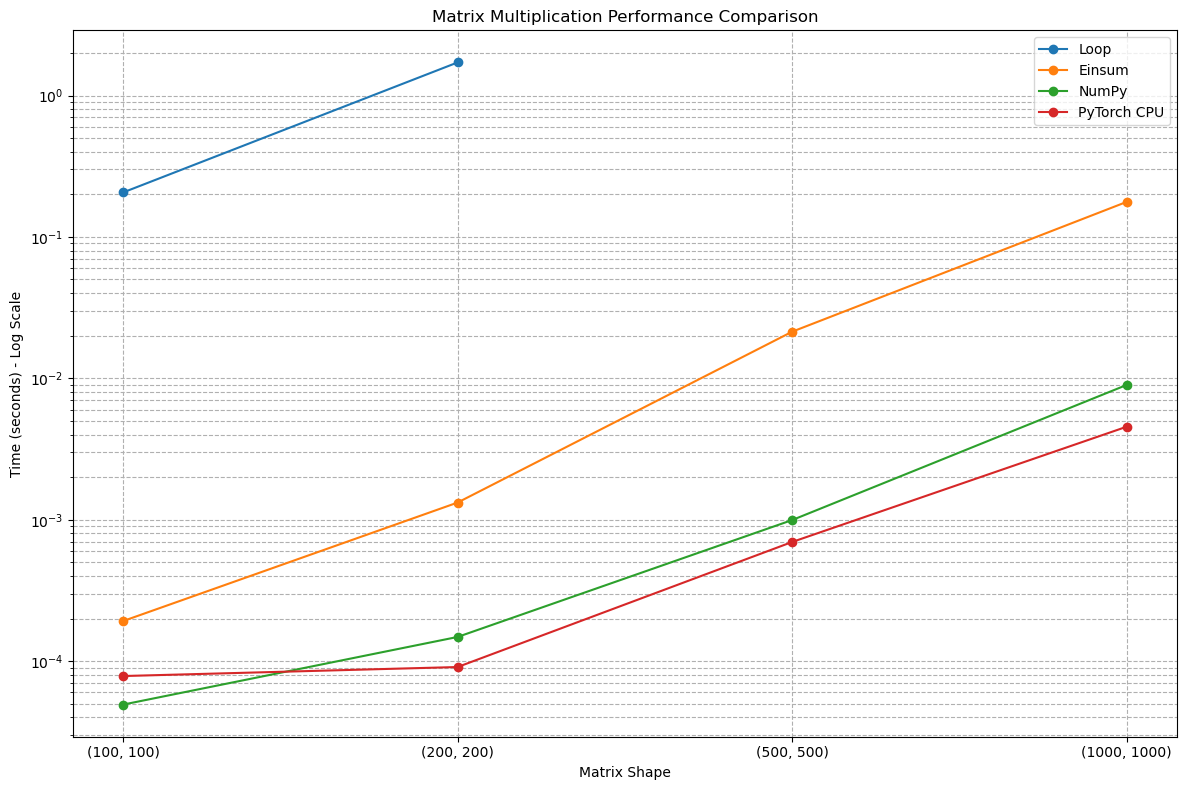

In [3]:
import time
import numpy as np
import torch

import matplotlib.pyplot as plt

def time_function(func, a, b, runs=10):
  """Time the execution of func(a, b) for 'runs' times and return the average."""
  times = []
  for _ in range(runs):
    start = time.time()
    func(a, b)
    end = time.time()
    times.append(end - start)
  return np.mean(times)

# Matrix shapes to test
shapes = [(100, 100), (200, 200), (500, 500), (1000, 1000)]
results = {'Loop': [], 'Einsum': [], 'NumPy': [], 'PyTorch CPU': [], 'PyTorch GPU': []}

for n in shapes:
  print(f"Testing matrices of shape {n}×{n}...")
  
  # Create random matrices
  a = np.random.random((n[0], n[1]))
  b = np.random.random((n[0], n[1]))
  
  # Create PyTorch tensors
  torch_a_cpu = torch.tensor(a, dtype=torch.float32)
  torch_b_cpu = torch.tensor(b, dtype=torch.float32)
  
  # Check if GPU is available
  if torch.cuda.is_available():
    torch_a_gpu = torch_a_cpu.cuda()
    torch_b_gpu = torch_b_cpu.cuda()
    # Warm-up GPU
    _ = torch.matmul(torch_a_gpu, torch_b_gpu)
  
  # Skip loop for large matrices
  if n[0] < 500:
    results['Loop'].append(time_function(matrix_mul_loop, a, b))
  else:
    results['Loop'].append(None)
  
  results['Einsum'].append(time_function(matrix_mul_einsum, a, b))
  results['NumPy'].append(time_function(matrix_mul_np, a, b))
  results['PyTorch CPU'].append(time_function(matrix_mul_cpu, torch_a_cpu, torch_b_cpu))
  
  if torch.cuda.is_available():
    results['PyTorch GPU'].append(time_function(matrix_mul_gpu, torch_a_gpu, torch_b_gpu))
  else:
    results['PyTorch GPU'].append(None)

# Plot results
plt.figure(figsize=(12, 8))
x = [str(s) for s in shapes]

for method, times in results.items():
  valid_times = [t for t in times if t is not None]
  if valid_times:
    plt.semilogy([s for s, t in zip(x, times) if t is not None], 
          valid_times, 
          marker='o', 
          label=method)

plt.xlabel('Matrix Shape')
plt.ylabel('Time (seconds) - Log Scale')
plt.title('Matrix Multiplication Performance Comparison')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()

# Test different matrix multiplication arrangements for square matrices
n = 1000
a = np.random.random((n, n))
b = np.random.random((n, n))
torch_a_cpu = torch.tensor(a, dtype=torch.float32)
torch_b_cpu = torch.tensor(b, dtype=torch.float32)
if torch.cuda.is_available():
  torch_a_gpu = torch_a_cpu.cuda()
  torch_b_gpu = torch_b_cpu.cuda()
  
  # Test the four multiplication cases
  labels = ["AB", "A^T B", "A B^T", "A^T B^T"]
  times = []
  
  # Case 1: AB
  start = time.time()
  _ = torch.matmul(torch_a_gpu, torch_b_gpu)
  torch.cuda.synchronize()
  times.append(time.time() - start)
  
  # Case 2: A^T B
  start = time.time()
  _ = torch.matmul(torch_a_gpu.t(), torch_b_gpu)
  torch.cuda.synchronize()
  times.append(time.time() - start)
  
  # Case 3: A B^T
  start = time.time()
  _ = torch.matmul(torch_a_gpu, torch_b_gpu.t())
  torch.cuda.synchronize()
  times.append(time.time() - start)
  
  # Case 4: A^T B^T
  start = time.time()
  _ = torch.matmul(torch_a_gpu.t(), torch_b_gpu.t())
  torch.cuda.synchronize()
  times.append(time.time() - start)
  
  # Plot the results
  plt.figure(figsize=(10, 6))
  plt.bar(labels, times)
  plt.xlabel('Matrix Multiplication Case')
  plt.ylabel('Time (seconds)')
  plt.title('Matrix Multiplication Performance for Different Cases')
  plt.grid(True, axis='y', ls='--')
  
  # Annotate the bar with the exact time
  for i, v in enumerate(times):
    plt.text(i, v + 0.0001, f"{v:.6f}s", ha='center')

## Problem 2: Stochastic Gradient Descent (training MNIST digits) [2p]

We provide below starter code that trains a classification model (with softmat + cross entropy loss). Alternatively, implement your own training loop and use it to solve this problem jointly with the next one.

Implement the following additions to the SGD code provided:
  1. **[1p]** momentum
  2. **[0.5p]** learning rate schedule
  3. **[0.5p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use the function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

## Problem 3: Tuning the Network for MNIST [2p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    a good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Please note: there are many hyperparameter settings that give the desired answer, some may require tuning all hyperparameters, some only a few.

## Problem 4*: Convolutional Network [2p]

Use convolutional and max-pooling layers (`Conv2d`, `Max_pool2d` or their functional variants) and (without dropout) get a test error rate below 1.5%.

Hint: see [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), [F.relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

## Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transformations during training, make sure they are re-computed in every epoch. Consider applying augmentation either in the training loop or in the `InMemDataLoader`. For the second case, function `InMemDataLoader.__iter__` is a good place to do it.


## Problem 6: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer 
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

## Problem 7: Batch Normalization [2p]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

## Problem 8: Norm Constraints [1p]

Implement norm constraints, i.e. instead of weight decay, that tries to set all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

## Problem 9: Hyperparameter tuner [2p]

Implement a hyper-parameter tuner able to optimize the learning rate schedule, number of neurons, and similar hyperparameters. To start, use a random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

## Problem 10: Pruning [1p]

Prune the MNIST network to retain validation accuracy no worse than 0.1 percentage point at maximum sparsity (maximal number of weights removed from the network).

One way to do it is to 
1. train the network, 
2. set to zero the smallest weights (typically you can zero up to 50% of weights)
3. retrain the network, keeping the zeroed weights zeroed, and repeat

## Problem 11: Other tricks [1p-many]

The neural network literature is full of tricks for training neural networks. Find some and implement them. Please note: the number of points depends on the hardness of the extension you want to implement. If in doubt, consult the TA beforehand

# Starter code

The code below trains a SoftMax regression model in PyTorch. It can easily be extended into a full multilayer neural network.

In [4]:
%matplotlib inline

In [5]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

/nix/store/2hlcdfiln1il5v65vlwjr205q898dw5z-python3-3.12.8-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

## Data loading

Training speed is important. By default, data is loaded on the CPU, then shipped in batches to the GPU. For this exercise, we will load the full dataset onto the GPU, which speeds up training.

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            # transform = v2.RandomCrop(size=(224, 224))
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

```python
# Monkey-patch MNIST to use a more robust MNIST mirror
torchvision.datasets.MNIST.resources = [
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]
```

In [8]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_47366/2199848925.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]
100%|██████████| 10000/10000 [00:00<00:00, 11977.03it/s]


## SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs while solving the assignments.

## Problem 2: Stochastic Gradient Descent (training MNIST digits) [2p]

We provide below starter code that trains a classification model (with softmat + cross entropy loss). Alternatively, implement your own training loop and use it to solve this problem jointly with the next one.

Implement the following additions to the SGD code provided:
  1. **[1p]** momentum
  2. **[0.5p]** learning rate schedule
  3. **[0.5p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use the function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

In [9]:
def SGD(
    model,
    data_loaders,
    lr=1e-4,
    l2_regularization_eps=0.0,
    lr_decay=0.8,
    momentum=0.05,
    num_epochs=10,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=2000,
    device="cpu",
    debug = True,
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    #
    # TODO for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros_like(p) for p in model.parameters()]
    #
    lr = lr
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #       
            # step based lr decay
            lr = lr * lr_decay
            
            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            #
                            # TODO for Problem 2.3: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            p.grad += l2_regularization_eps * p # + as we add square to loss, including 2* in the decay param
                            # ^ couldnt this be independent of any eps? and biased towards some sane numbers, not 0?

                        #
                        # TODO for Problem 2.2: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        lr = lr
                        #

                        #
                        # TODO for Problem 2.1: If needed, implement here a momentum schedule
                        # epsilon = TODO
                        #
                        

                        #
                        # TODO for Problem 2.1: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        #
                        v[...] = ((1-momentum) * p.grad + momentum * v)

                        #
                        # TODO for Problem 2: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        #
                        p -= lr * v

                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    if debug:
                        print(
                            "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                                iter_,
                                loss.item(),
                                batch_err_rate * 100.0,
                                num_iter / (time.time() - tstart),
                            )
                        )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            if debug:
                clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

----------------------------------------------------------
After epoch 20 | valid err rate: 10.83% | doing  20 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 13)

-------------------------------------------
Test error rate: 11.380%, training took 4s.
-------------------------------------------


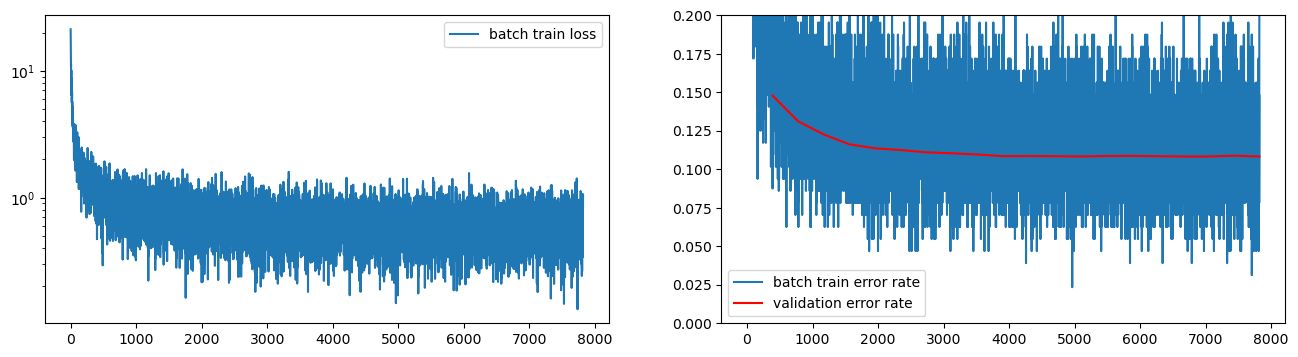

In [60]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(nn.Linear(28 * 28, 10))

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, lr=1e-1, max_num_epochs=30, device="cpu")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

In [11]:
# 2. Suggest values of the hyperparameters using a trial object.
n_layers = 3
layers = []

in_features = 28 * 28
for i in range(n_layers):
    out_features = 100*(i+1)
    layers.append(torch.nn.Linear(in_features, out_features))
    layers.append(torch.nn.ReLU())
    in_features = out_features
layers.append(torch.nn.Linear(in_features, 10))
layers.append(torch.nn.LogSoftmax(dim=1))
model = torch.nn.Sequential(*layers)

# with torch.no_grad():
#     # Initialize parameters
#     for name, p in model.named_parameters():
#       print(name)
#       print(p.shape[1])


In [12]:
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    n_layers = trial.suggest_int('n_layers', 1, 2)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 100, 5000)
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(torch.nn.ELU())
        in_features = out_features
    layers.append(torch.nn.Linear(in_features, 10))
    layers.append(torch.nn.LogSoftmax(dim=1))
    model = Model(*layers)
    
    with torch.no_grad():
        # Initialize parameters
        for name, p in model.named_parameters():
            if "weight" in name:
                sqr = p.shape[1] ** 0.5
                p.uniform_( -1 / sqr, 1 / sqr)
            elif "bias" in name:
                p.zero_()
            else:
                raise ValueError('Unknown parameter name "%s"' % name)

    # lr = trial.suggest_float(f'lr', 1e-1, 1e-2)
    lr = 1e-1
    l2_regularization_eps = trial.suggest_float(f'l2_regularization_eps', 1e-3, 1)
    lr_decay = trial.suggest_float(f'lr_decay', 1e-2, 1)
    momentum = trial.suggest_float(f'momentum', 1e-2, 1)
    num_epochs = 10

    print(f"training with: {layers}, lr: {lr}, l2_regularization_eps: {l2_regularization_eps}, lr_decay: {lr_decay}, momentum: {momentum}, num_epochs: {num_epochs}")

    # On GPU enabled devices set device='cuda' else set device='cpu'
    t_start = time.time()
    SGD(model, mnist_loaders, 
        lr=lr,
        l2_regularization_eps=l2_regularization_eps,
        lr_decay=lr_decay,
        momentum=momentum,
        num_epochs=num_epochs,
        max_num_epochs=50,
        device="cpu")

    test_err_rate = compute_error_rate(model, mnist_loaders["test"])

    m = (
        f"Test error rate: {test_err_rate * 100.0:.3f}%, "
        f"training took {time.time() - t_start:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))

    return test_err_rate

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///db.sqlite3"
    )

# commented because below its same but refactored
# study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=12, gc_after_trial=True)

[I 2025-04-05 13:11:43,380] A new study created in RDB with name: no-name-3c162e24-6bb4-4425-8a8f-c6f4f6797e78


In [ ]:
import optuna

# layer_types

def dense_model(n_layers, n_units):
    # 2. Suggest values of the hyperparameters using a trial object.
    layers = []
    in_features = 28 * 28
    for i in range(n_layers):
        # out_features = trial.suggest_int(f'n_units_l{i}', 100, 5000)
        out_features = n_units[i]
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(torch.nn.ELU())
        in_features = out_features
    layers.append(torch.nn.Linear(in_features, 10))
    layers.append(torch.nn.LogSoftmax(dim=1))
    return Model(*layers)
  
def initialize_weights(model):
  with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            sqr = p.shape[1] ** 0.5
            p.uniform_( -1 / sqr, 1 / sqr)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

def train(model, lr,
  l2_regularization_eps,
  lr_decay,
  momentum,
  num_epochs):
  
  print(f"training with: {model}, lr: {lr}, l2_regularization_eps: {l2_regularization_eps}, lr_decay: {lr_decay}, momentum: {momentum}, num_epochs: {num_epochs}")

  # On GPU enabled devices set device='cuda' else set device='cpu'
  t_start = time.time()
  SGD(model, mnist_loaders, 
        lr=lr,
        l2_regularization_eps=l2_regularization_eps,
        lr_decay=lr_decay,
        momentum=momentum,
        num_epochs=num_epochs,
        max_num_epochs=50,
        device="cpu",
        debug=False)

  test_err_rate = compute_error_rate(model, mnist_loaders["test"])

  m = (
      f"Test error rate: {test_err_rate * 100.0:.3f}%, "
      f"training took {time.time() - t_start:.0f}s."
  )
  print("{0}\n{1}\n{0}".format("-" * len(m), m))

  return test_err_rate

# 1. Define an objective function to be maximized.
def objective(trial):
        
    # lr = trial.suggest_float(f'lr', 1e-1, 1e-2)
    lr = 1e-1
    l2_regularization_eps = trial.suggest_float(f'l2_regularization_eps', 1e-3, 1)
    lr_decay = trial.suggest_float(f'lr_decay', 1e-1, 1)
    momentum = trial.suggest_float(f'momentum', 1e-2, 0.2)
    num_epochs = 10
    n_layers = trial.suggest_int('n_layers', 1, 2)

    n_units = []
    for i in range(n_layers):
      out_features = trial.suggest_int(f'n_units_l{i}', 100, 5000)
      n_units.append(out_features)
    
    model = dense_model(n_layers, n_units)
    initialize_weights(model)
    err_rate = train(model, lr, l2_regularization_eps, lr_decay, momentum, num_epochs)
    return err_rate


[I 2025-04-05 13:11:43,429] A new study created in RDB with name: no-name-0638cfe3-e6f2-40b0-9500-7078e1da678d
  0%|          | 0/4 [00:00<?, ?it/s]

training with: Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=4980, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=4980, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
), lr: 0.1, l2_regularization_eps: 0.5492619671642409, lr_decay: 0.3924222400419419, momentum: 0.5312235058959667, num_epochs: 10
Training the model!
Interrupt at any time to evaluate the best validation model so far.
training with: Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1174, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1174, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
), lr: 0.1, l2_regularization_eps: 0.6701001896099461, lr_decay: 0.2725893933584945, momentum: 0.8850890472082938, num_epochs: 10
Training the model!
Interrupt at any time to evaluate the best validation model so far.
training with: Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1919, bias=True)
   

Best trial: 3. Best value: 0.2484:  25%|██▌       | 1/4 [06:03<18:10, 363.58s/it]

---------------------------------------------
Test error rate: 24.840%, training took 363s.
---------------------------------------------
[I 2025-04-05 13:17:46,960] Trial 3 finished with value: 0.2484 and parameters: {'l2_regularization_eps': 0.6701001896099461, 'lr_decay': 0.2725893933584945, 'momentum': 0.8850890472082938, 'n_layers': 1, 'n_units_l0': 1174}. Best is trial 3 with value: 0.2484.
----------------------------------------------------------
After epoch  5 | valid err rate: 89.36% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  6 | valid err rate: 19.34% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  6 | valid err rate: 89.36% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoc

Best trial: 3. Best value: 0.2484:  50%|█████     | 2/4 [10:47<10:33, 316.58s/it]

---------------------------------------------
Test error rate: 88.650%, training took 647s.
---------------------------------------------
[I 2025-04-05 13:22:30,655] Trial 1 finished with value: 0.8865 and parameters: {'l2_regularization_eps': 0.9865519615171354, 'lr_decay': 0.4123868568534294, 'momentum': 0.5070727011664163, 'n_layers': 2, 'n_units_l0': 1919, 'n_units_l1': 1098}. Best is trial 3 with value: 0.2484.
----------------------------------------------------------
After epoch 11 | valid err rate: 19.31% | doing  14 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 12 | valid err rate: 19.31% | doing  14 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 13 | valid err rate: 19.31% | doing  14 epochs
----------------------------------------------------------
-------------------------------------------------

Best trial: 2. Best value: 0.2023:  75%|███████▌  | 3/4 [12:43<03:45, 225.16s/it]

---------------------------------------------
Test error rate: 20.230%, training took 763s.
---------------------------------------------
[I 2025-04-05 13:24:27,030] Trial 2 finished with value: 0.2023 and parameters: {'l2_regularization_eps': 0.5492619671642409, 'lr_decay': 0.3924222400419419, 'momentum': 0.5312235058959667, 'n_layers': 1, 'n_units_l0': 4980}. Best is trial 2 with value: 0.2023.
----------------------------------------------------------
After epoch  6 | valid err rate: 25.54% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  7 | valid err rate: 25.54% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  8 | valid err rate: 25.54% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoc

Best trial: 2. Best value: 0.2023: 100%|██████████| 4/4 [17:45<00:00, 266.31s/it]

----------------------------------------------
Test error rate: 26.380%, training took 1065s.
----------------------------------------------
[I 2025-04-05 13:29:28,684] Trial 0 finished with value: 0.2638 and parameters: {'l2_regularization_eps': 0.30462866706473196, 'lr_decay': 0.31314732124587835, 'momentum': 0.27871735931305514, 'n_layers': 2, 'n_units_l0': 2954, 'n_units_l1': 3240}. Best is trial 2 with value: 0.2023.


{'l2_regularization_eps': 0.5492619671642409,
 'lr_decay': 0.3924222400419419,
 'momentum': 0.5312235058959667,
 'n_layers': 1,
 'n_units_l0': 4980}

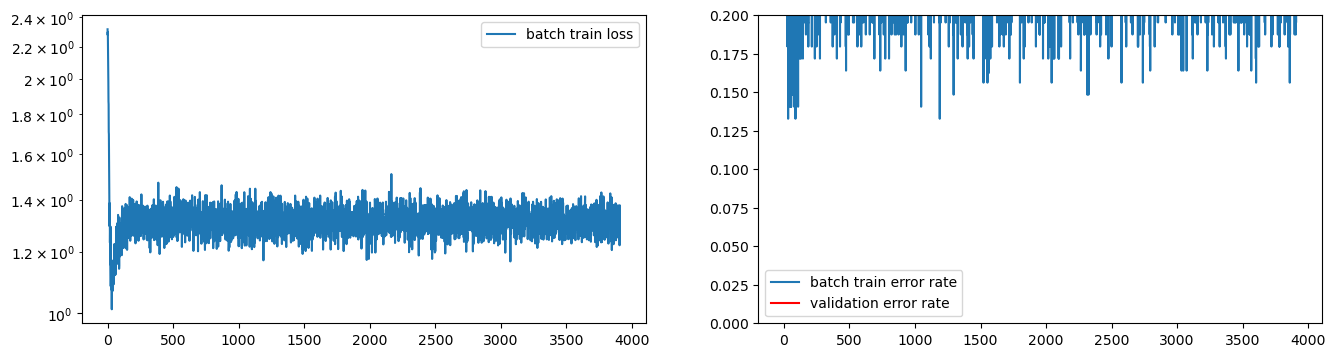

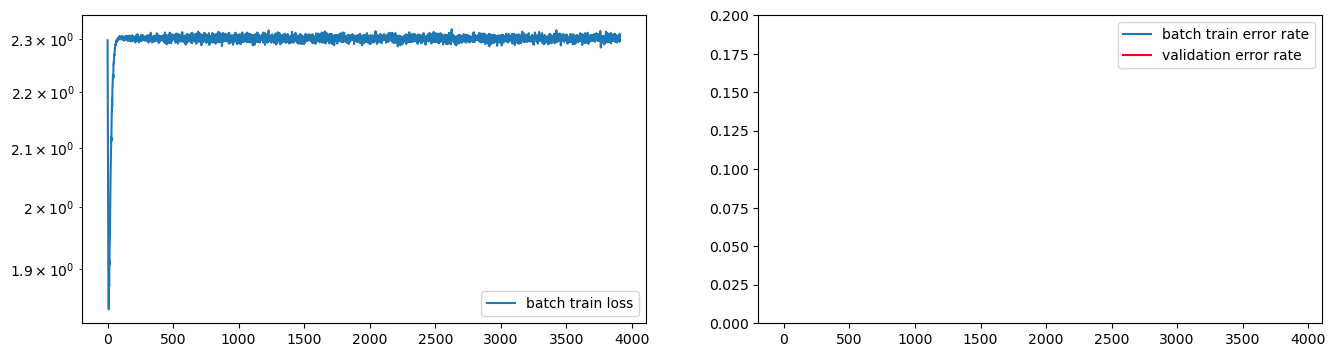

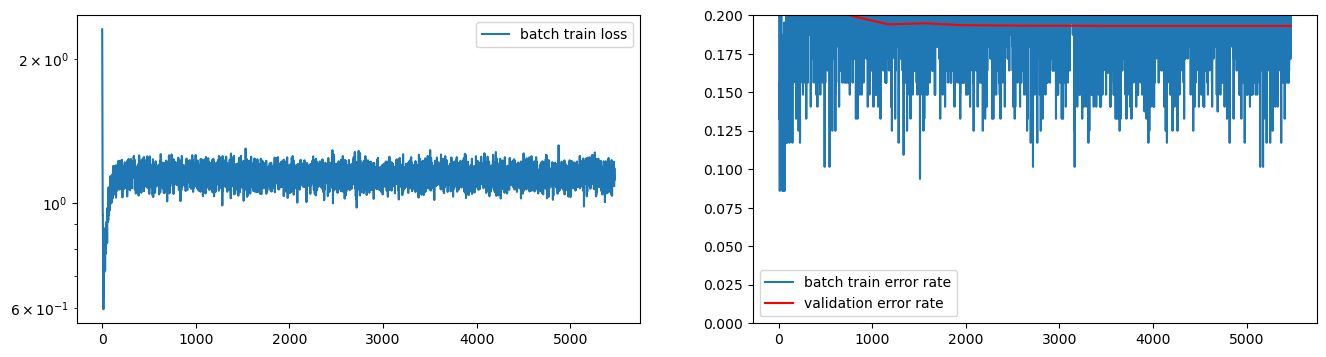

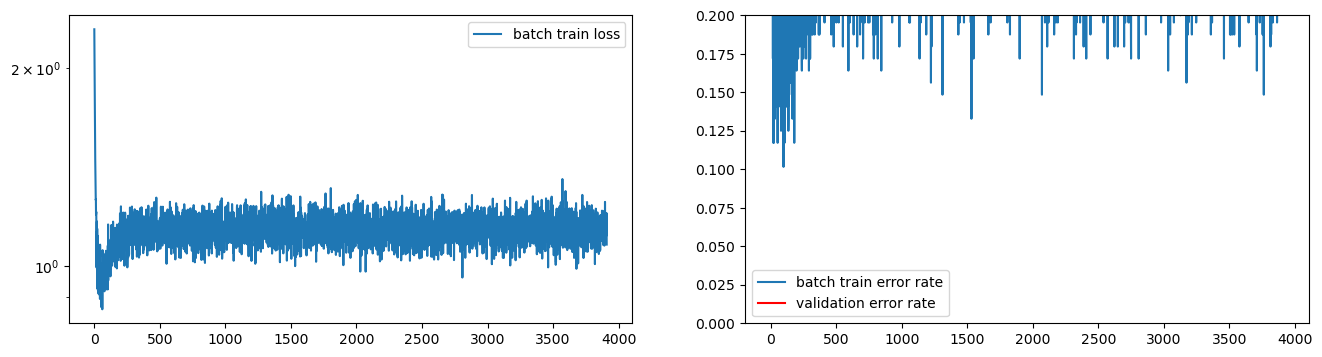

In [14]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///db.sqlite3"
    )

study.optimize(objective, n_trials=4, show_progress_bar=True, n_jobs=12, gc_after_trial=False)
study.best_params

In [ ]:
# def conv_model(n_layers, n_units):
#     # 2. Suggest values of the hyperparameters using a trial object.
#     layers = []
#     in_features = 28 * 28
#     for i in range(n_layers):
#         # out_features = trial.suggest_int(f'n_units_l{i}', 100, 5000)
#         out_features = n_units[i]
#         layers.append(torch.nn.Linear(in_features, out_features))
#         layers.append(torch.nn.ELU())
#         in_features = out_features
#     layers.append(torch.nn.Linear(in_features, 10))
#     layers.append(torch.nn.LogSoftmax(dim=1))
#     return Model(*layers)

# conv_model = Model()

training with: Model(
  (layers): Sequential(
    (0): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(1, 28, 28))
      (1): PrintLayer()
      (2): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=3200, out_features=128, bias=True)
      (9): ReLU()
      (10): Linear(in_features=128, out_features=10, bias=True)
      (11): LogSoftmax(dim=1)
    )
  )
), lr: 0.1, l2_regularization_eps: 0.01, lr_decay: 0.8, momentum: 0.01, num_epochs: 10
Training the model!
Interrupt at any time to evaluate the best validation model so far.
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([1

0.0161

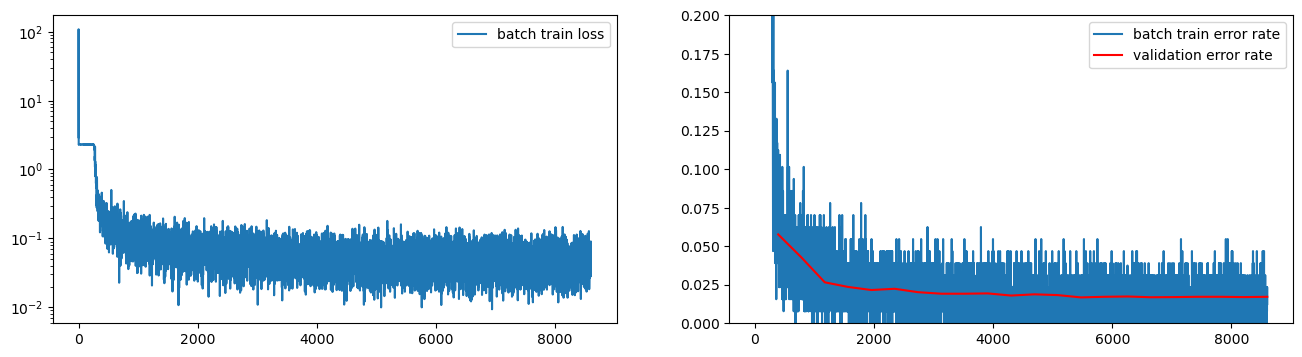

In [59]:
from torchvision.transforms import Resize

class PrintLayer(nn.Module):
  def __init__(self):
      super(PrintLayer, self).__init__()
  def forward(self, x):
      print(x.shape)
      return x
    
conv_model = Model(nn.Sequential(
  nn.Unflatten(1, (1, 28, 28)),
  PrintLayer(),
  nn.Conv2d(1, 16, 5), # in_c, out_c, kernel_size,  40960x20 ??
  nn.ReLU(),
  nn.Conv2d(16, 32, 5),
  nn.ReLU(),
  nn.MaxPool2d((2,2)),
  nn.Flatten(),
  nn.Linear(3200, 128),
  nn.ReLU(),
  nn.Linear(128, 10),
  nn.LogSoftmax(dim=1)
))

initialize_weights(conv_model)
err_rate = train(conv_model, lr=0.1, l2_regularization_eps=0.01, lr_decay=0.8, momentum=0.01, num_epochs=10)
err_rate

torch.Size([128, 1, 28, 28])

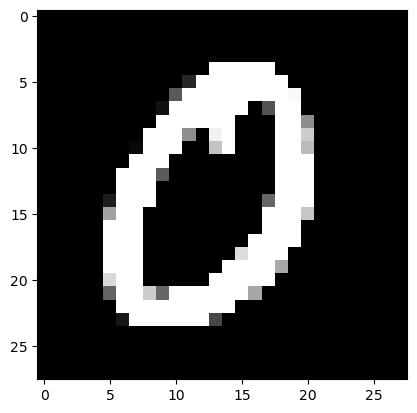

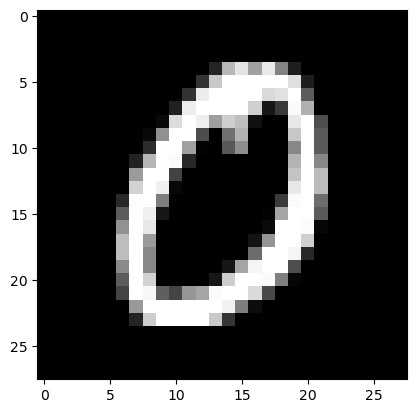

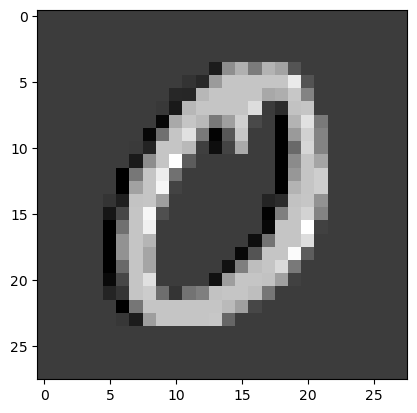

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
from matplotlib import pyplot as plt
from torchvision.transforms import v2
# transform = v2.RandomCrop(size=(28, 28))
# transform = v2.Normalize(mean=0.485, std=0.229)
# transform = v2.RandomHorizontalFlip(p=0.5)
# transform = v2.RandomResizedCrop(size=(28, 28), antialias=True)
# transform = v2.ScaleJitter(target_size=(28, 28))
transform = v2.Compose([
  v2.GaussianNoise(),
  v2.RandomAffine((-7, 7), (0.1, 0.1))
])

for x, y in mnist_loaders["train"]:
  display(x.shape)
  # Display the first image in the batch
  # img = x[0].squeeze()  # Remove the channel dimension
  # display(img)
  img = x[0]
  # plt.figure(figsize=(6, 6))
  # plt.imshow(img, cmap='gray')
  tr = transform(img)
  tr = tr.squeeze()
  img = img.squeeze()
  plt.imshow(tr, cmap='gray')
  plt.show()
  plt.imshow(img, cmap='gray')
  plt.show()
  # plt.imshow(img - tr.to(torch.float), cmap='gray')
  plt.imshow(img - tr, cmap='gray')
  plt.show()
  break
